In [20]:
from datasets import load_dataset
from datasets import Dataset, DatasetDict, concatenate_datasets, Value, Features
import re
import matplotlib.pyplot as plt
import json
from pathlib import Path

In [23]:
ds = load_dataset("gneubig/aime-1983-2024")

Generating train split: 100%|██████████| 933/933 [00:00<00:00, 15897.07 examples/s]


In [25]:
def to_question_answer(dd: DatasetDict) -> Dataset:
    ds = dd["train"]
    ds = ds.rename_columns({"Question": "question", "Answer": "answer"})
    ds = ds.remove_columns([c for c in ds.column_names if c not in ["question", "answer"]])
    return ds

In [26]:
aime_ds = to_question_answer(ds)  

In [28]:
def save_as_jsonl(ds: Dataset, path: str):
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)

    with path.open("w", encoding="utf-8") as f:
        for i, row in enumerate(ds):
            obj = {
                "id": f"aime-{i+1}",
                "question": row["question"],
                "final": str(row["answer"]).strip(),
            }
            f.write(json.dumps(obj, ensure_ascii=False) + "\n")

In [ ]:
save_as_jsonl(aime_ds, "../datasets/AIME/test.jsonl")

# Construct accuracy curves

In [1]:
import sys

sys.path.append("..")

from scripts.load_results import load_results
from strategic_ttc.verifiers.boxed_number import parse_pred_from_explanation
from scripts.accuracy_analysis import (
    plot_model_curves,
    plot_all_curves,
    plot_all_curves_delta,
    reasoning_accuracy_curve_second_custom,
    plot_reasoning_curve_2,
    compute_curves_for_model_fast
)

/NL/strategic-compute/work/svenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
results = load_results("../final_runs/AIME")
maj_mean, maj_std, rew_mean, rew_std = {}, {}, {}, {}
token_mean, token_std = {}, {}
thetas = {}

Processing file: Llama-3.2-1B--temp-0.6--samples-128--max-512.jsonl
Processing file: Qwen2-7B--temp-0.7--samples-128--max-512.jsonl
Processing file: Qwen2.5-7B--temp-0.7--samples-128--max-512.jsonl
Processing file: Llama-3.1-8B--temp-0.6--samples-128--max-512.jsonl
Processing file: Qwen2.5-3B--temp-0.7--samples-128--max-512.jsonl
Processing file: reason-R1-D-Qwen-1.5B--temp-0.6--samples-32--max-2048.jsonl
Processing file: Llama-3-8B--temp-0.6--samples-128--max-512.jsonl
Processing file: Qwen2-1.5B--temp-0.7--samples-128--max-512.jsonl
Processing file: reason-R1-D-Llama-8B--temp-0.6--samples-32--max-2048.jsonl
Processing file: Llama-3.2-3B--temp-0.6--samples-128--max-512.jsonl
Processing file: Qwen2-0.5B--temp-0.7--samples-128--max-512.jsonl
Processing file: reason-R1-D-Qwen-7B--temp-0.6--samples-32--max-2048.jsonl


In [3]:
reasoning_models = [
    "reason-R1-D-Llama-8B--temp-0.6",
    "reason-R1-D-Qwen-1.5B--temp-0.6",
    "reason-R1-D-Qwen-7B--temp-0.6",
]

In [4]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.titlesize": 10,
    "axes.labelsize": 9,
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "figure.dpi": 300,
    "axes.grid": True,
    "grid.alpha": 0.3,
    "grid.linestyle": "--"
})


Processing model: Llama-3.2-1B--temp-0.6


100%|██████████| 6/6 [00:00<00:00, 53.05it/s]


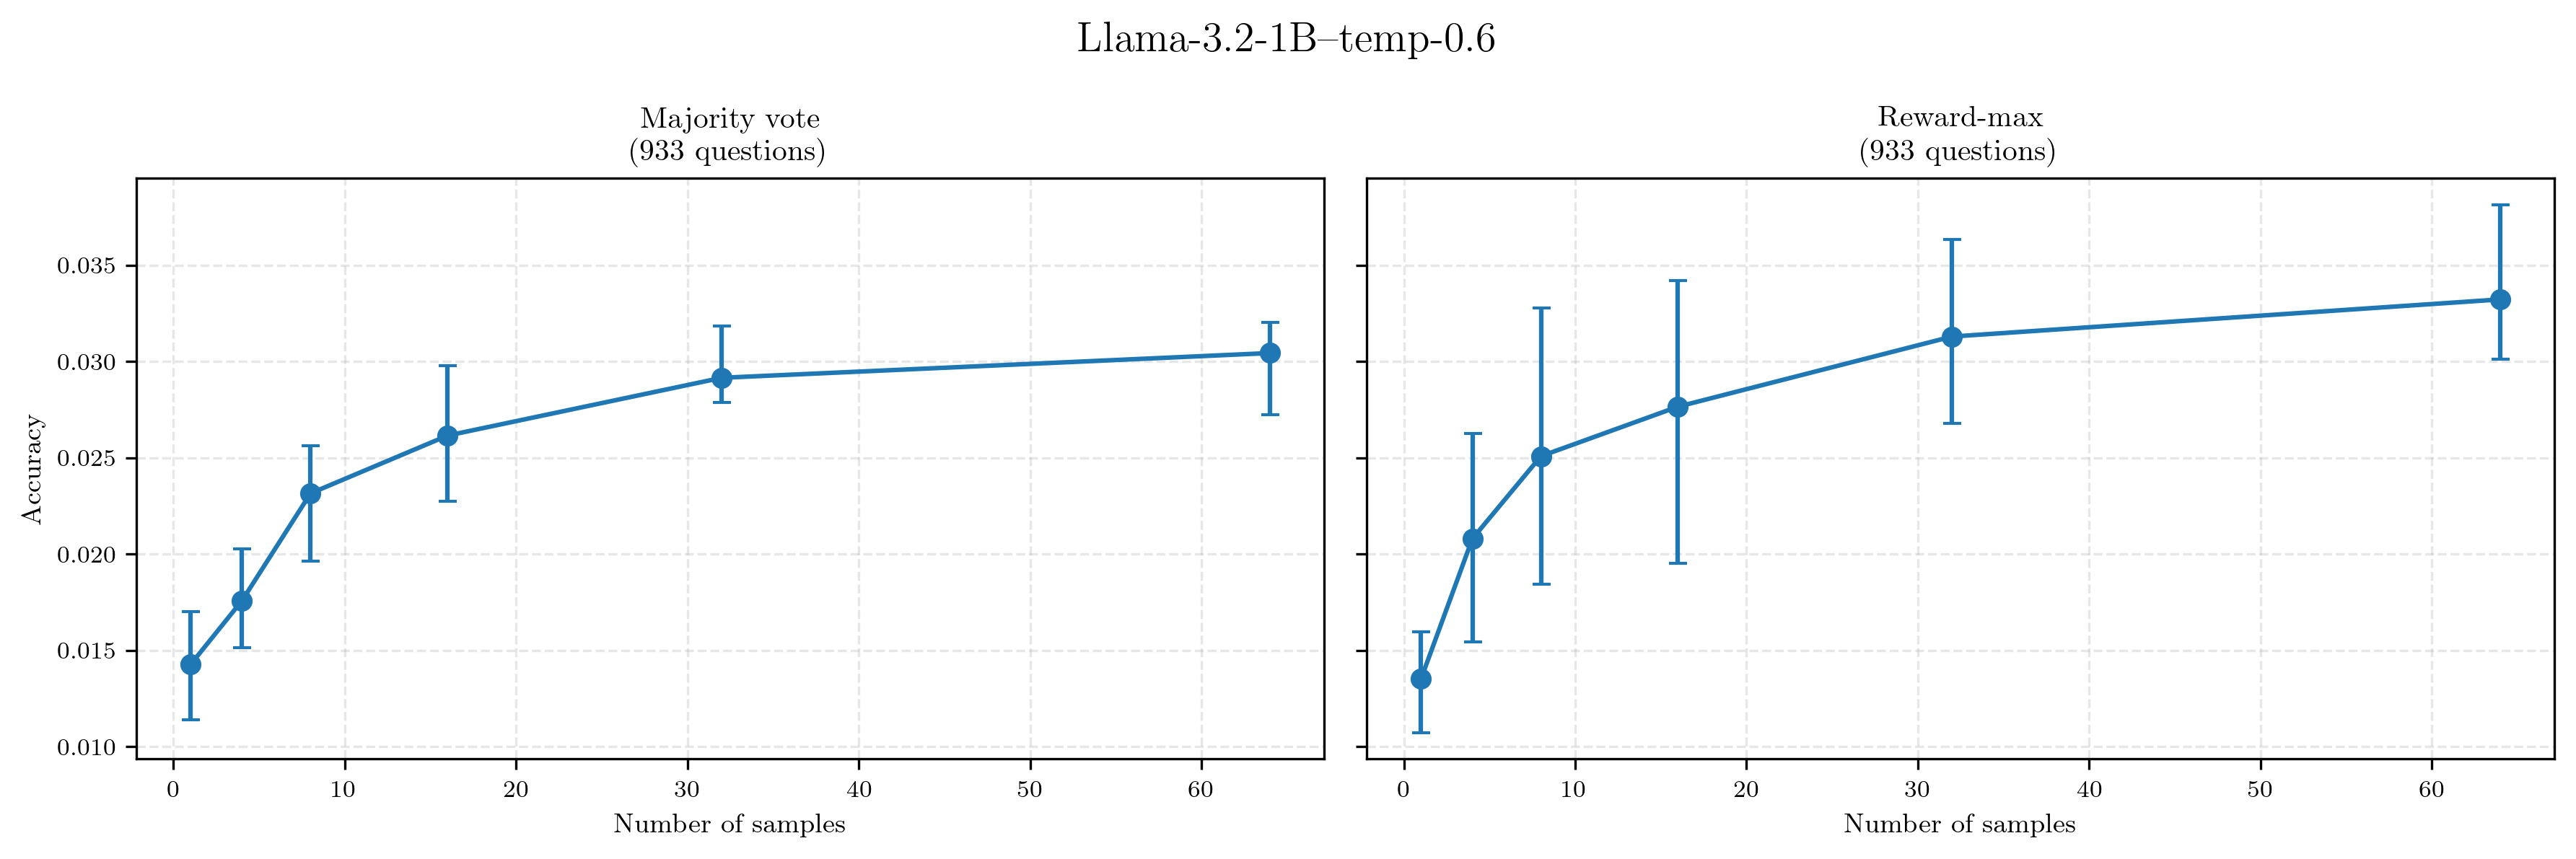

Processing model: Qwen2-7B--temp-0.7


100%|██████████| 6/6 [00:00<00:00, 59.24it/s]


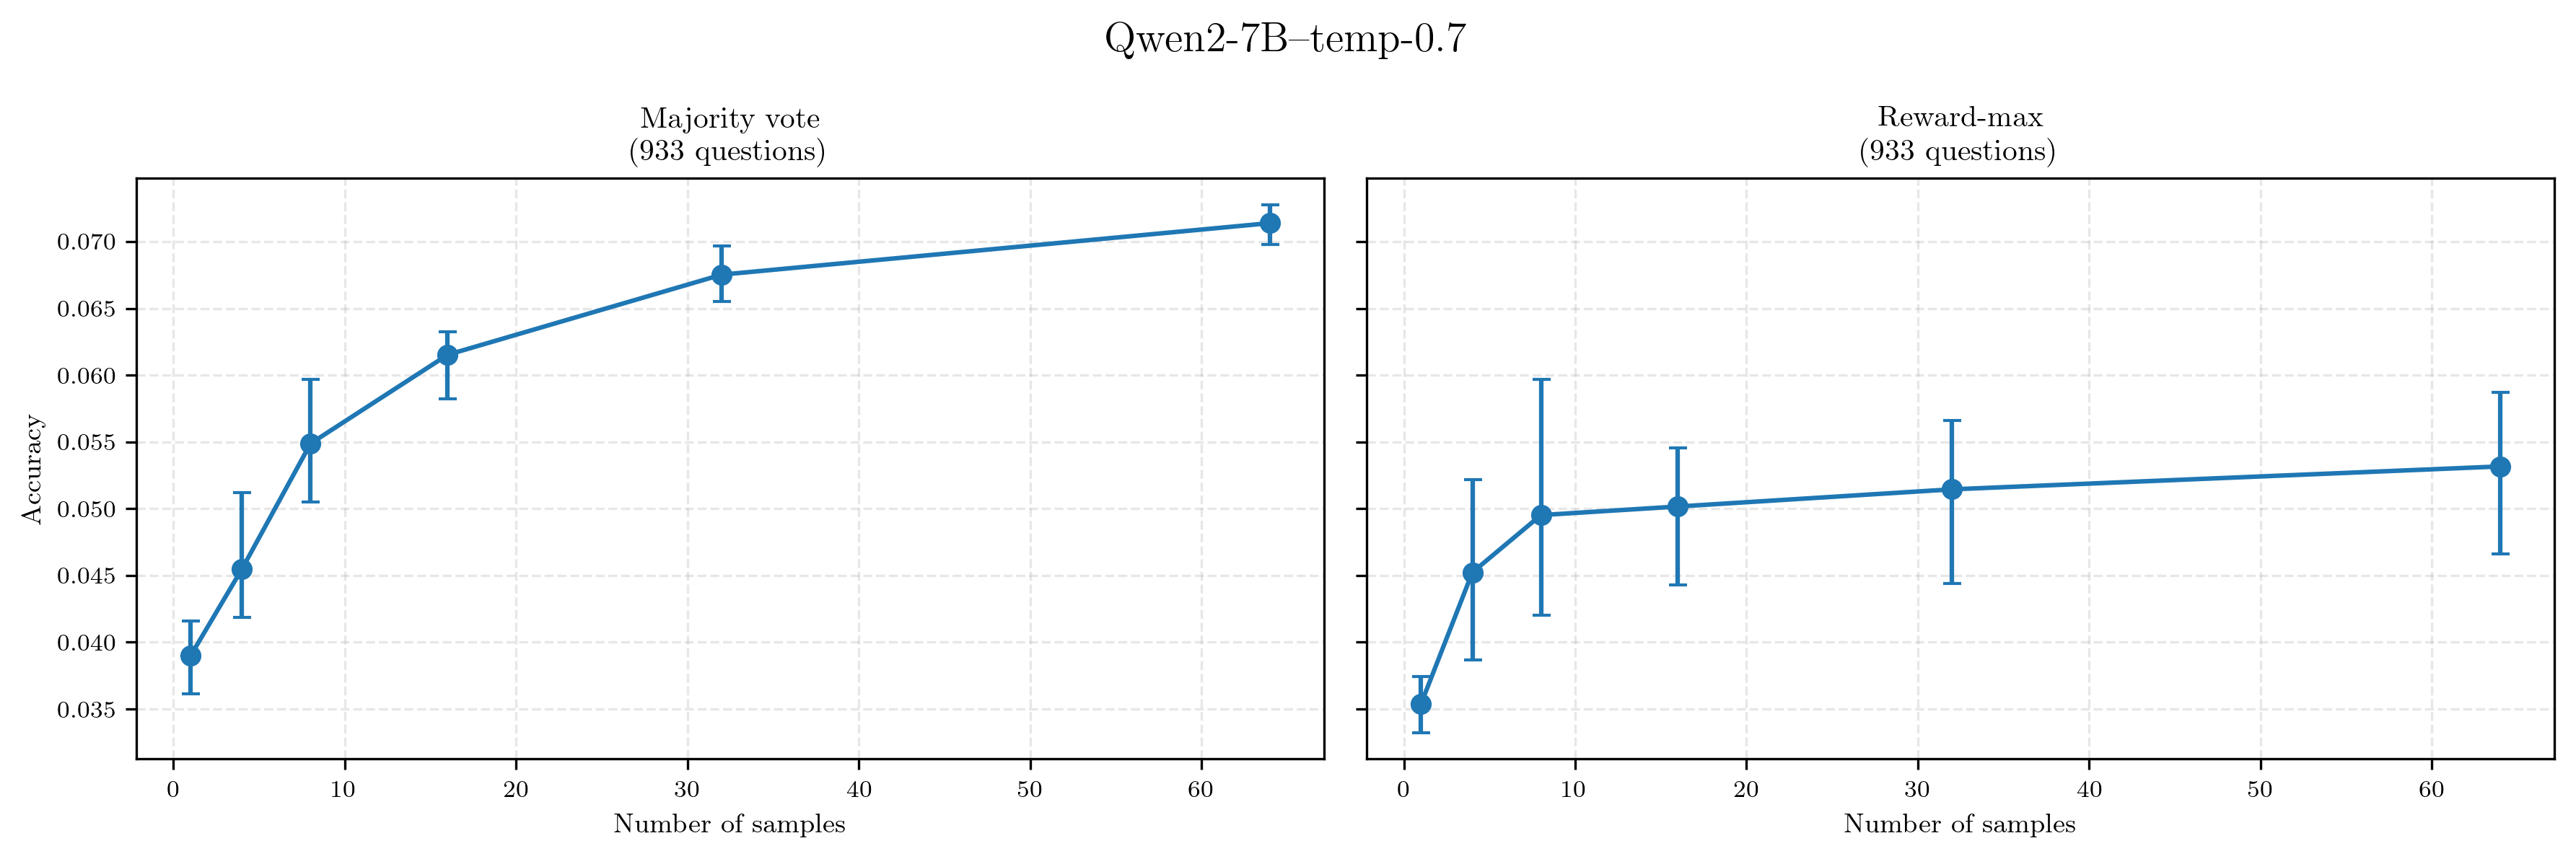

Processing model: Qwen2.5-7B--temp-0.7


100%|██████████| 6/6 [00:00<00:00, 60.27it/s]


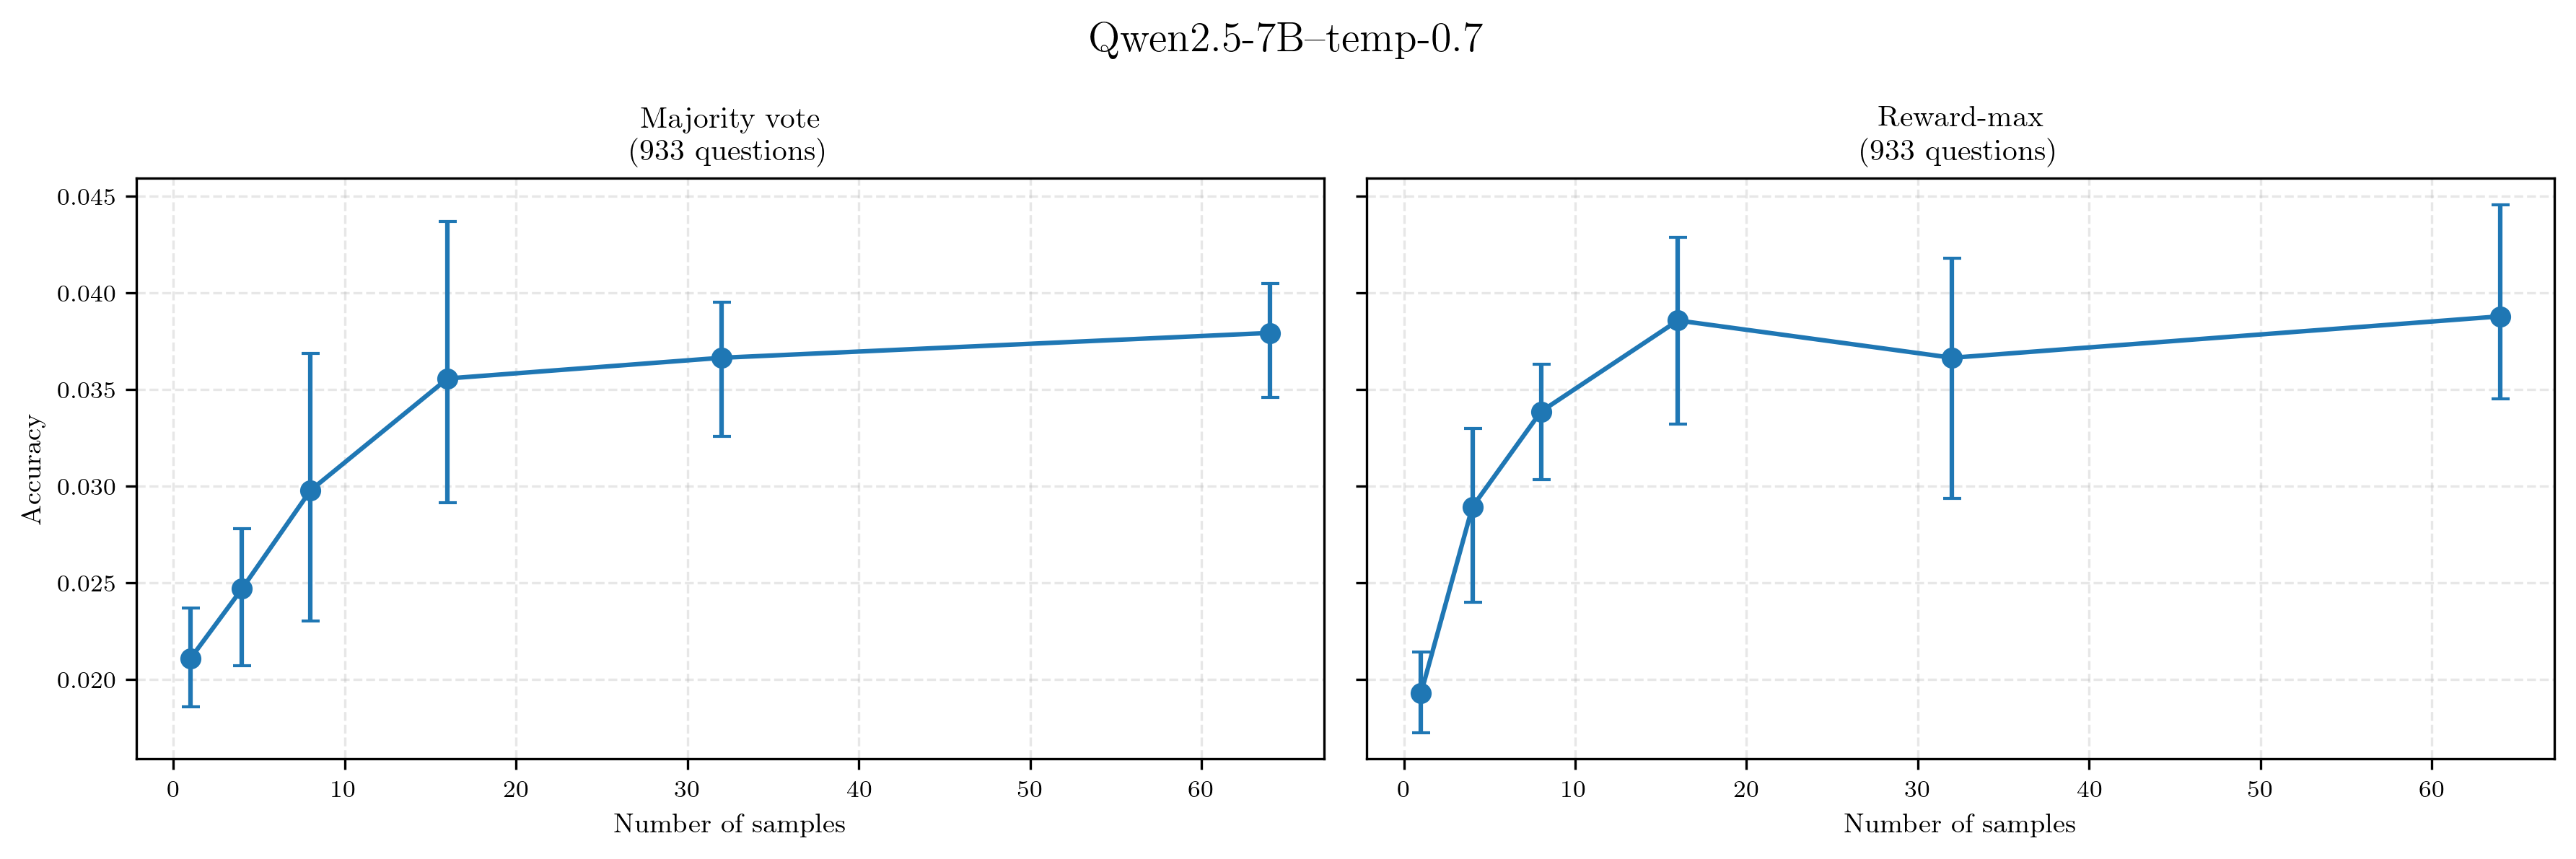

Processing model: Llama-3.1-8B--temp-0.6


100%|██████████| 6/6 [00:00<00:00, 59.14it/s]


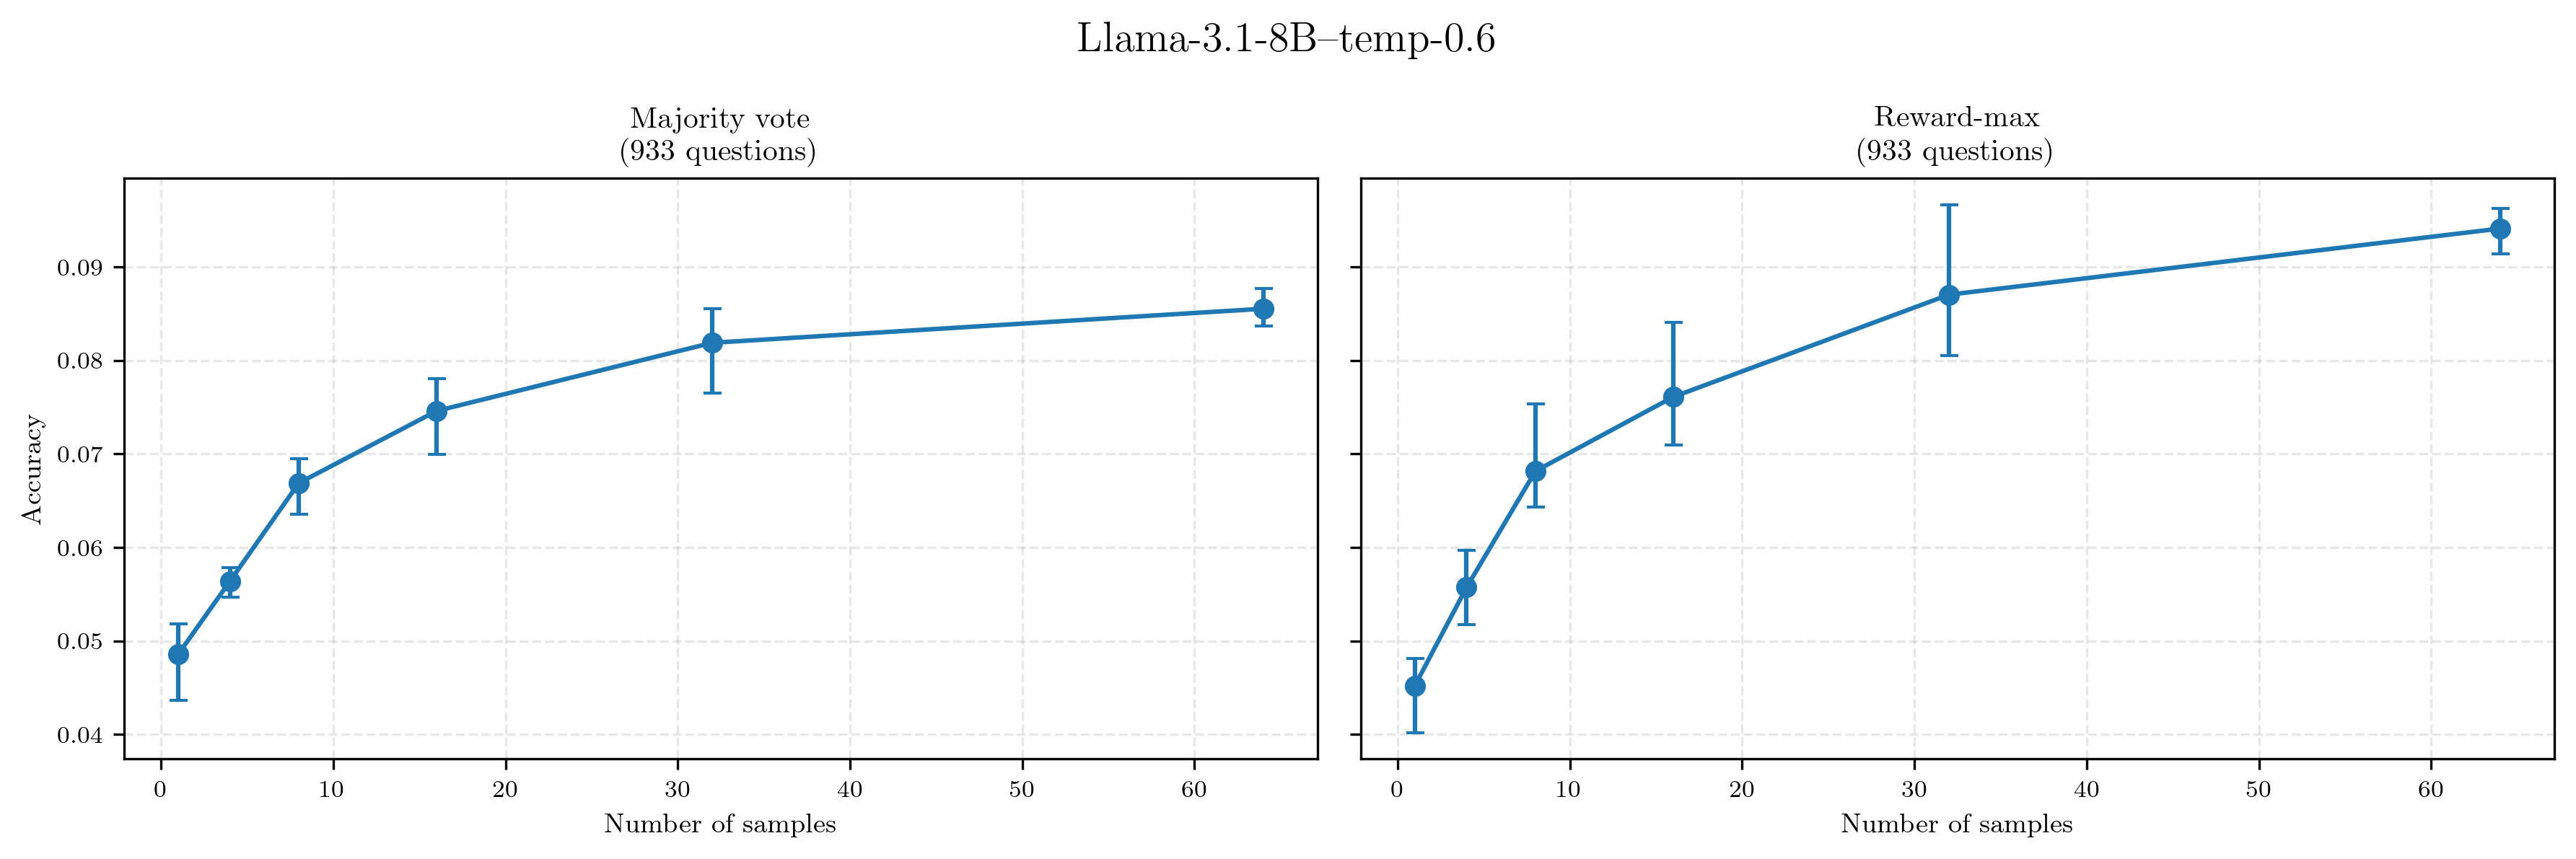

Processing model: Qwen2.5-3B--temp-0.7


100%|██████████| 6/6 [00:00<00:00, 63.47it/s]


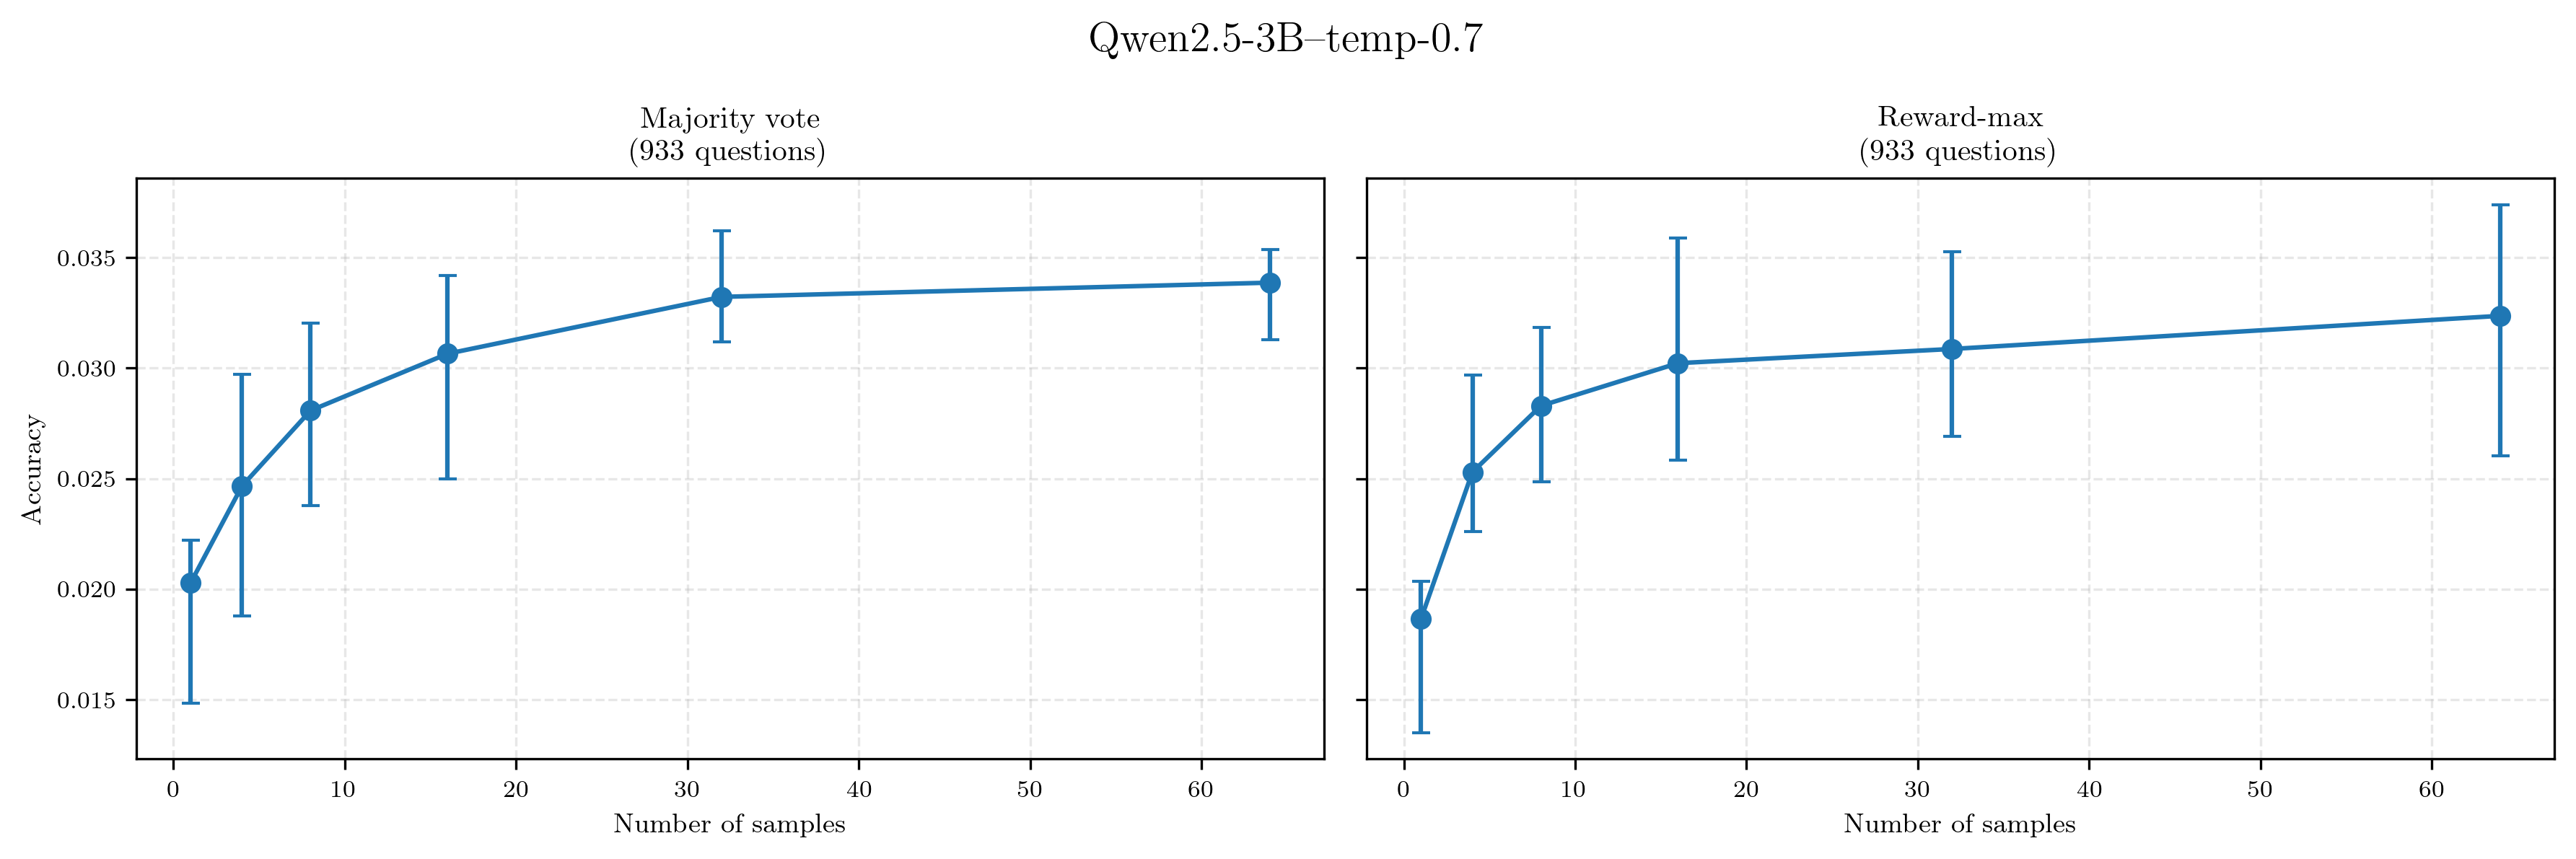

Processing model: Llama-3-8B--temp-0.6


100%|██████████| 6/6 [00:00<00:00, 63.24it/s]


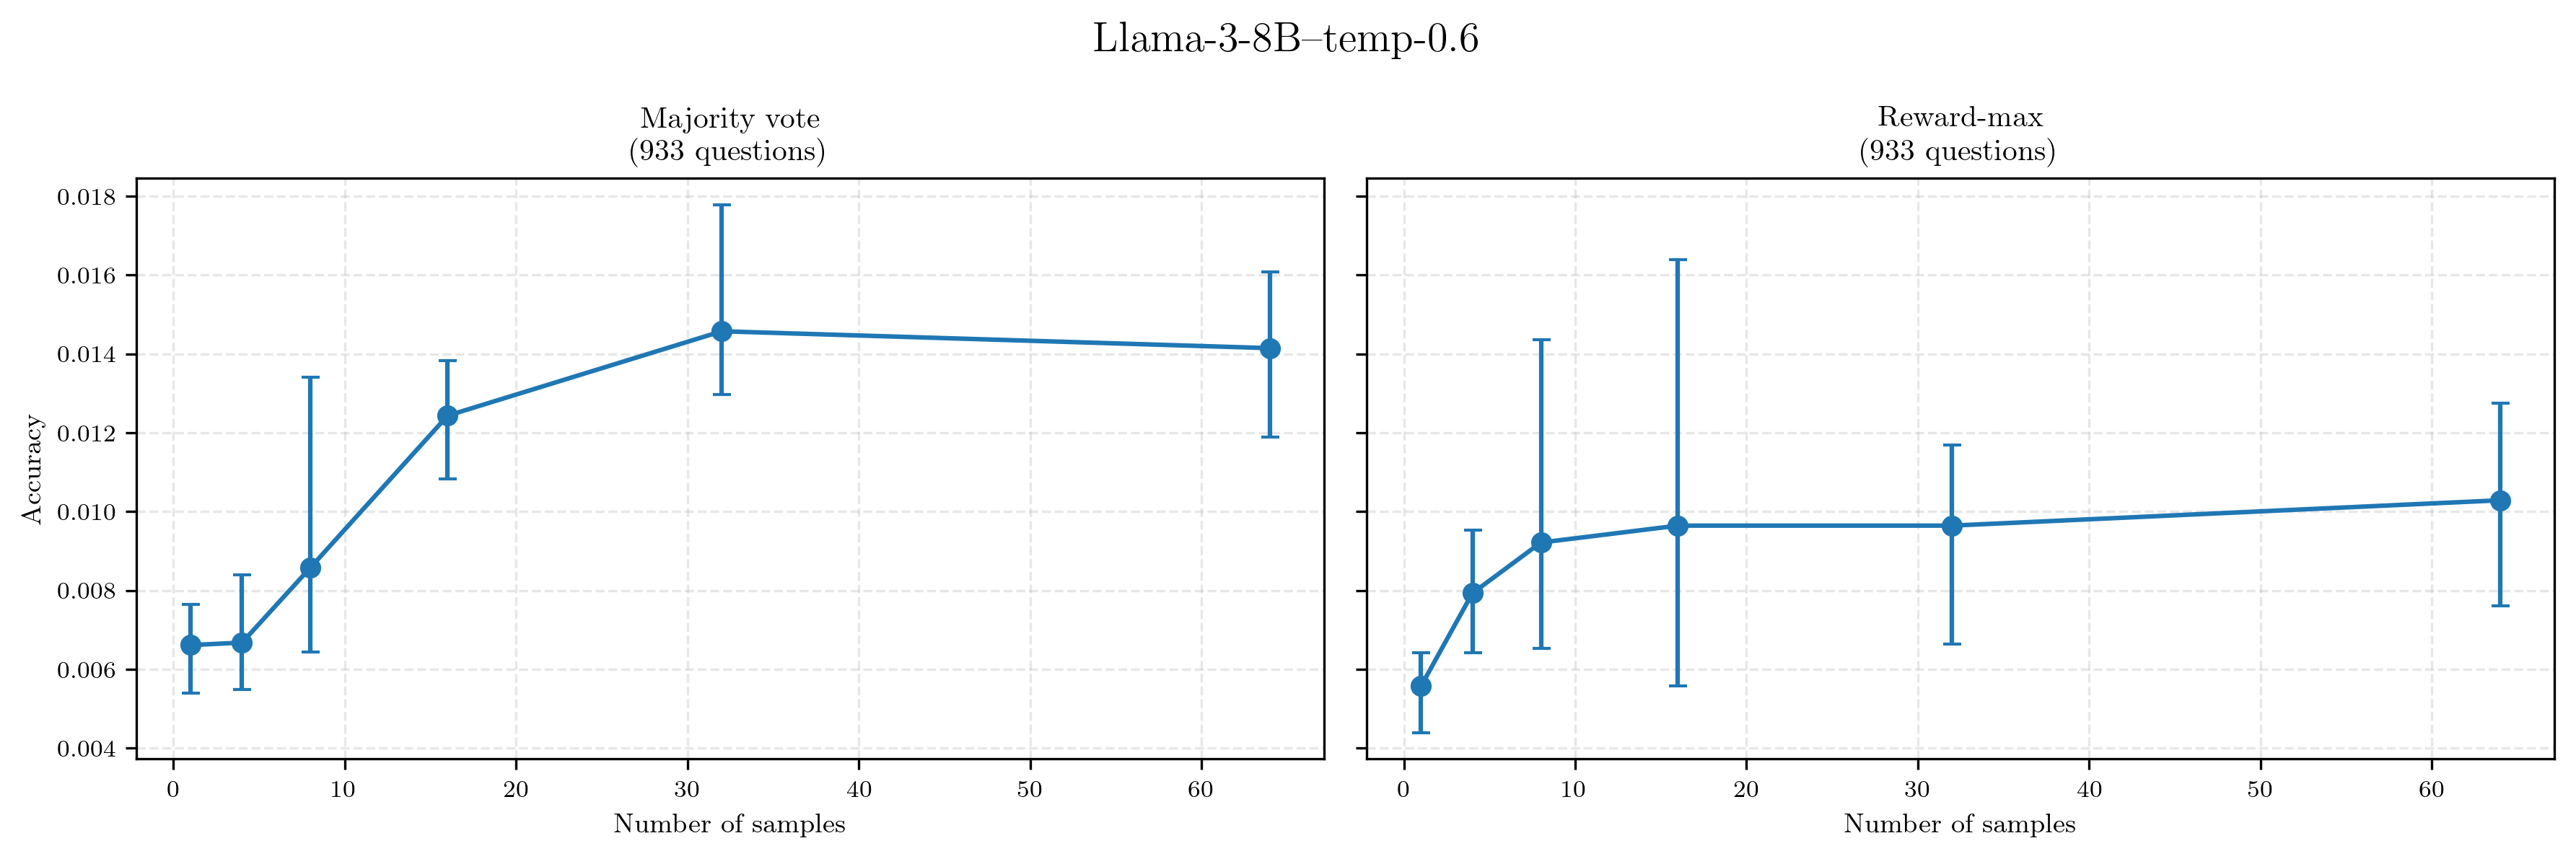

Processing model: Qwen2-1.5B--temp-0.7


100%|██████████| 6/6 [00:00<00:00, 61.93it/s]


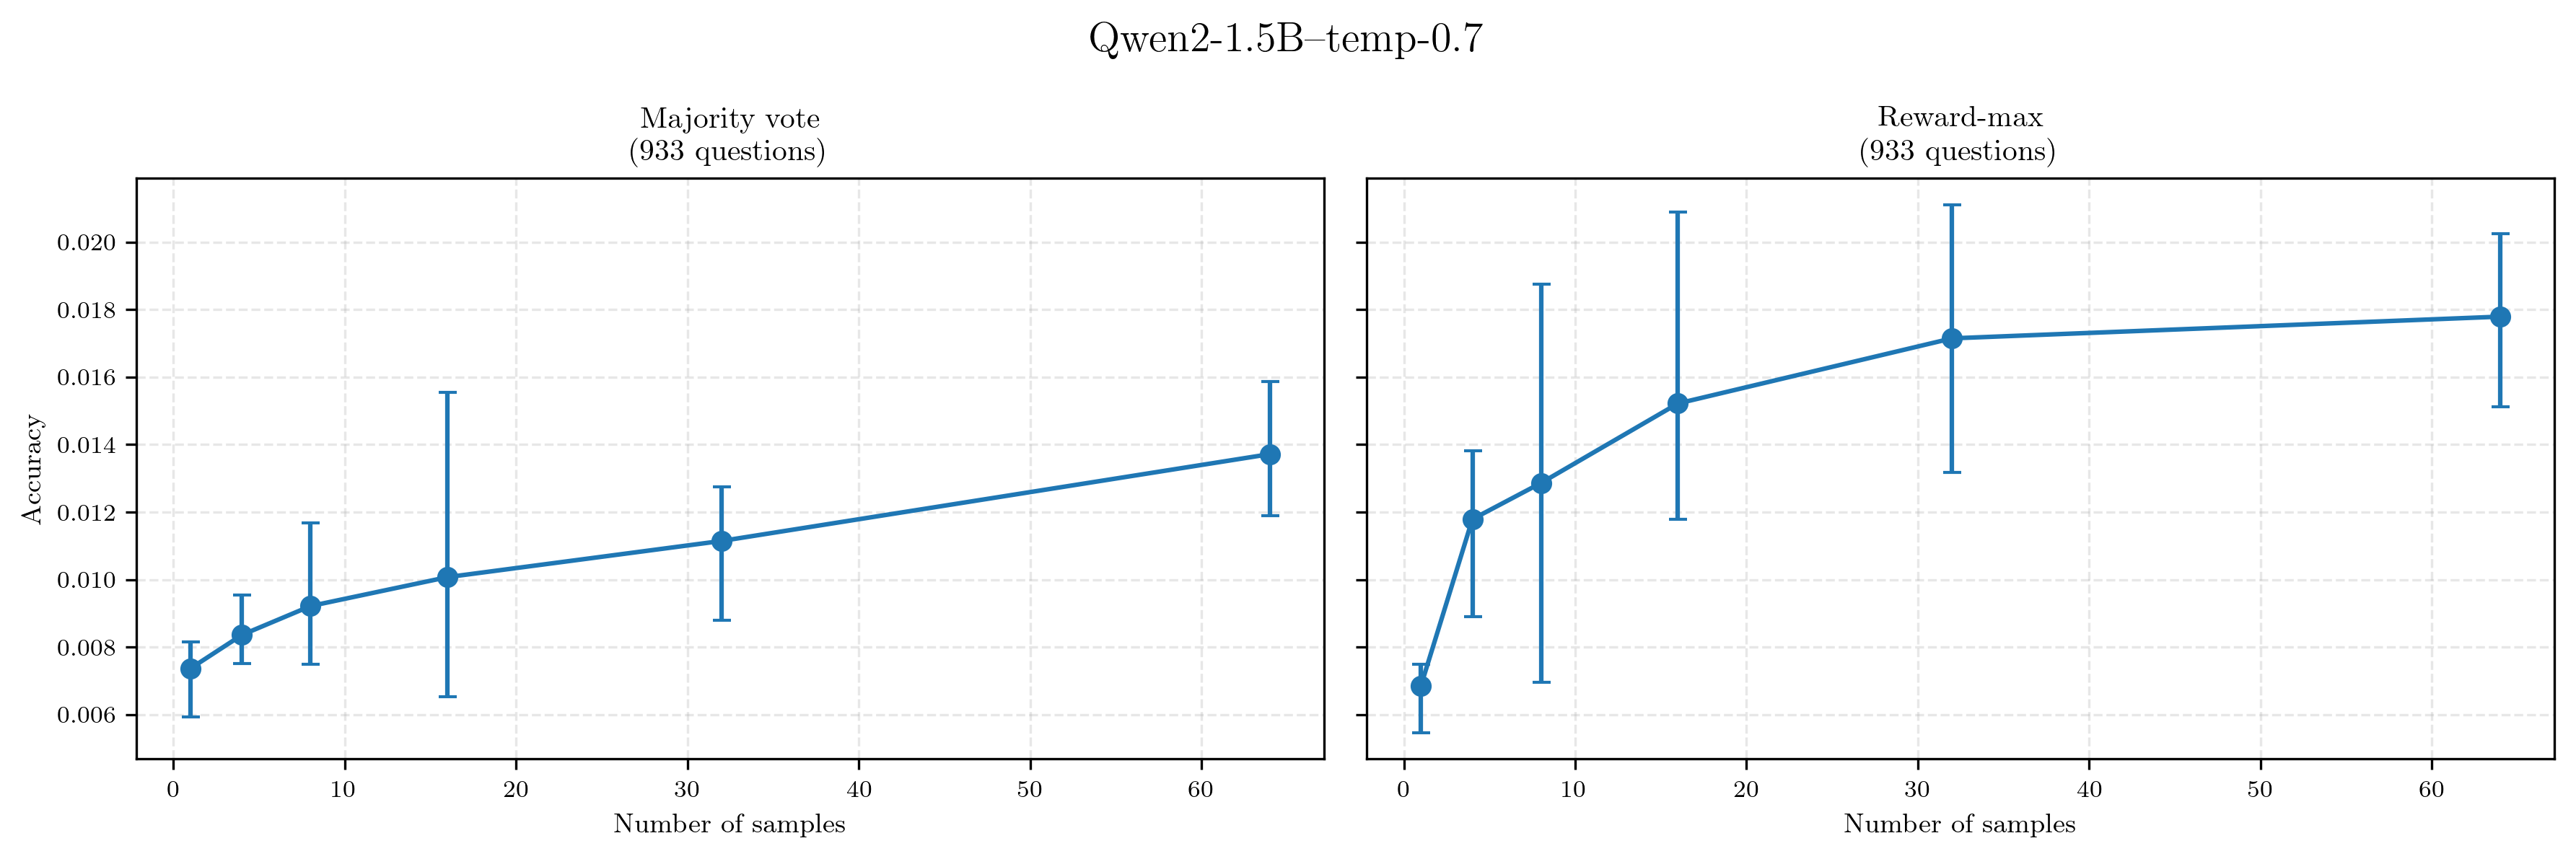

Processing model: Llama-3.2-3B--temp-0.6


100%|██████████| 6/6 [00:00<00:00, 63.36it/s]


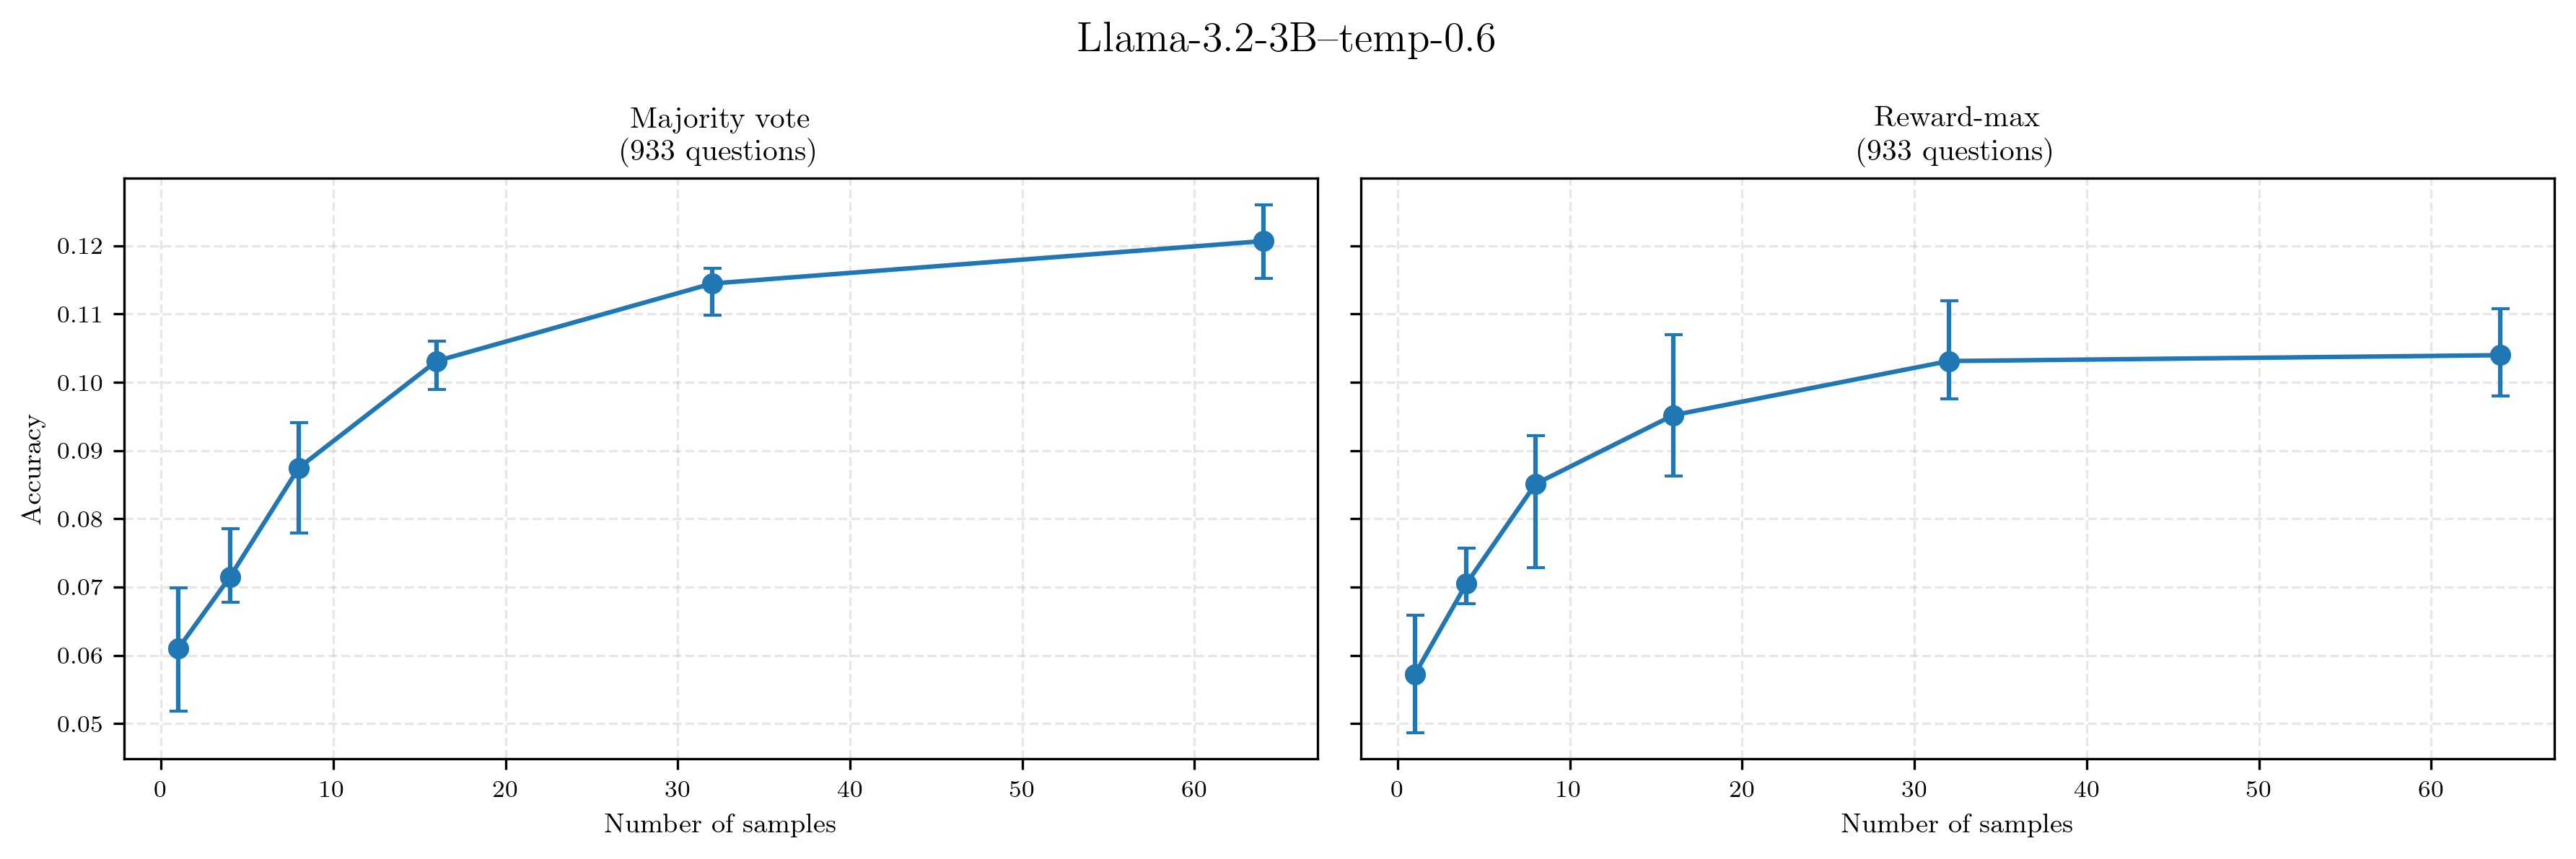

Processing model: Qwen2-0.5B--temp-0.7


100%|██████████| 6/6 [00:00<00:00, 63.02it/s]


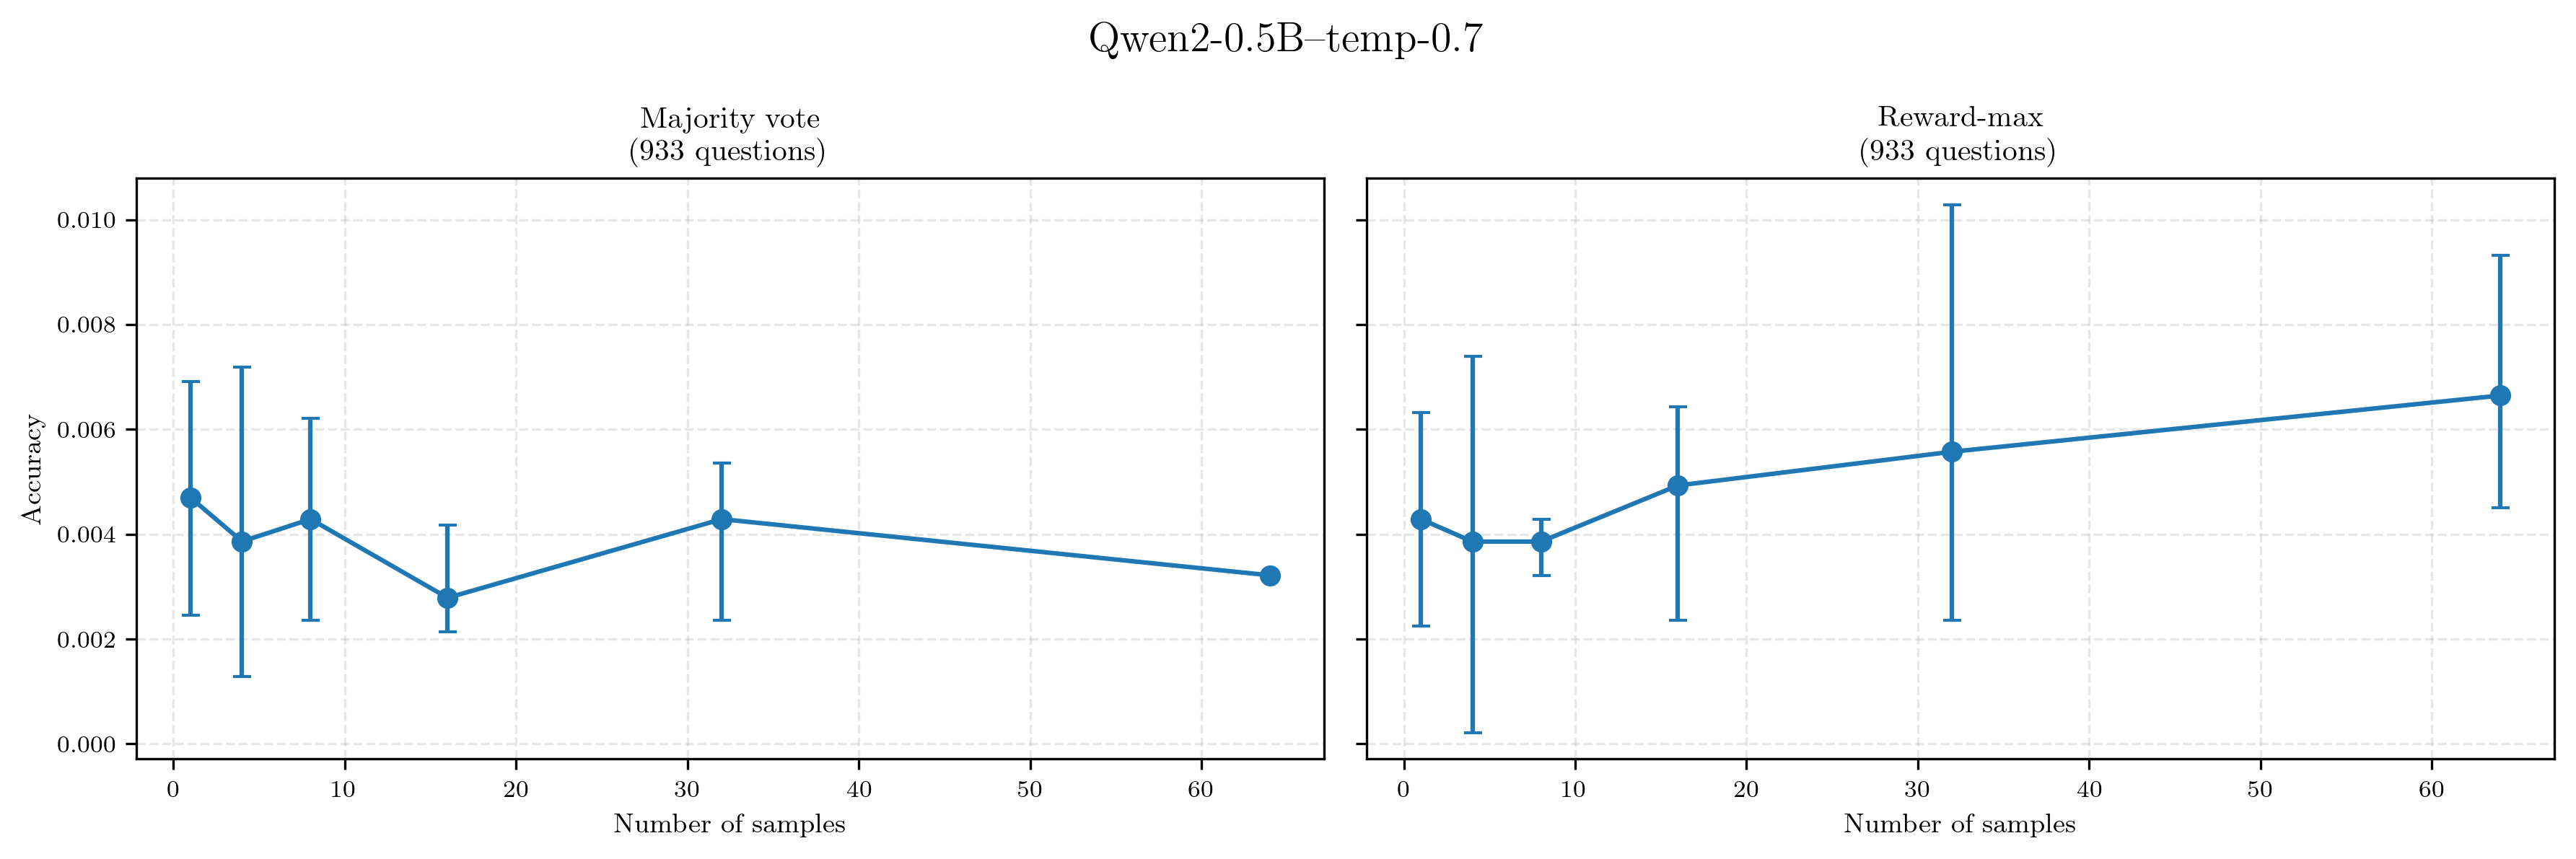

In [5]:
for model_name, data in results.items():
    if model_name in reasoning_models:
        continue
    print(f"Processing model: {model_name}")
    (
        thetas[model_name],
        maj_mean[model_name],
        maj_std[model_name],
        rew_mean[model_name],
        rew_std[model_name],
        token_mean[model_name],
        token_std[model_name],
    ) = compute_curves_for_model_fast(
        data,
        parse_pred_fn=parse_pred_from_explanation,
        sample_size=5,
    )
    plot_model_curves(
        model_name,
        thetas[model_name],
        maj_mean[model_name],
        maj_std[model_name],
        rew_mean[model_name],
        rew_std[model_name],
        len(data["correct"]),
    )

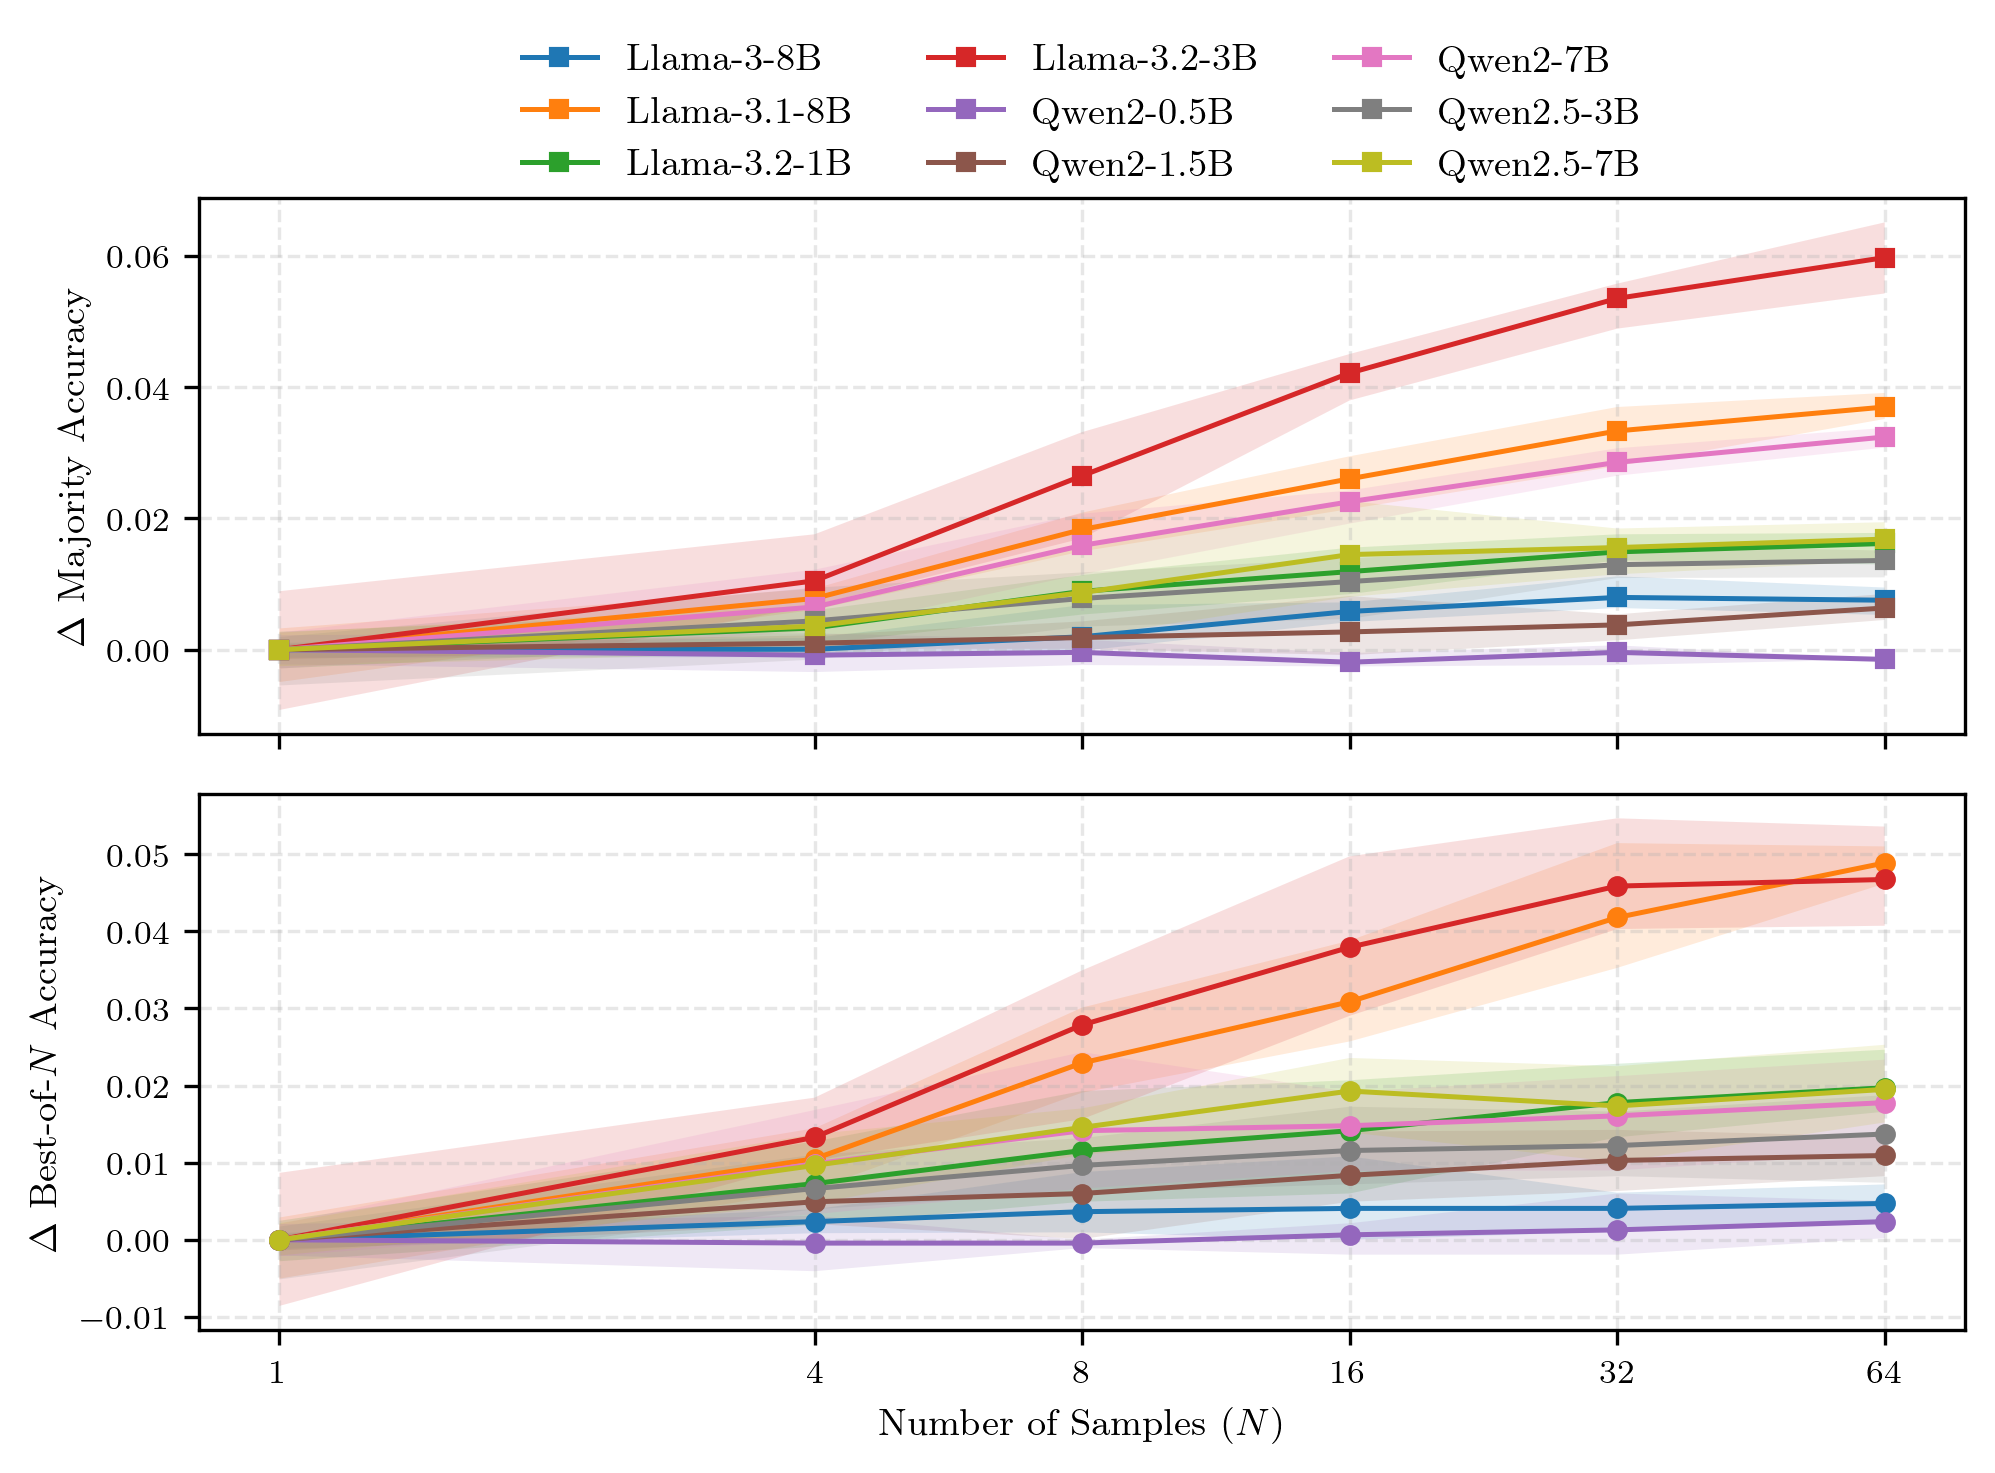

In [6]:
plot_all_curves_delta(
    thetas, maj_mean, maj_std, rew_mean, rew_std, filename="../figures/GSM8K/curves.pdf"
)

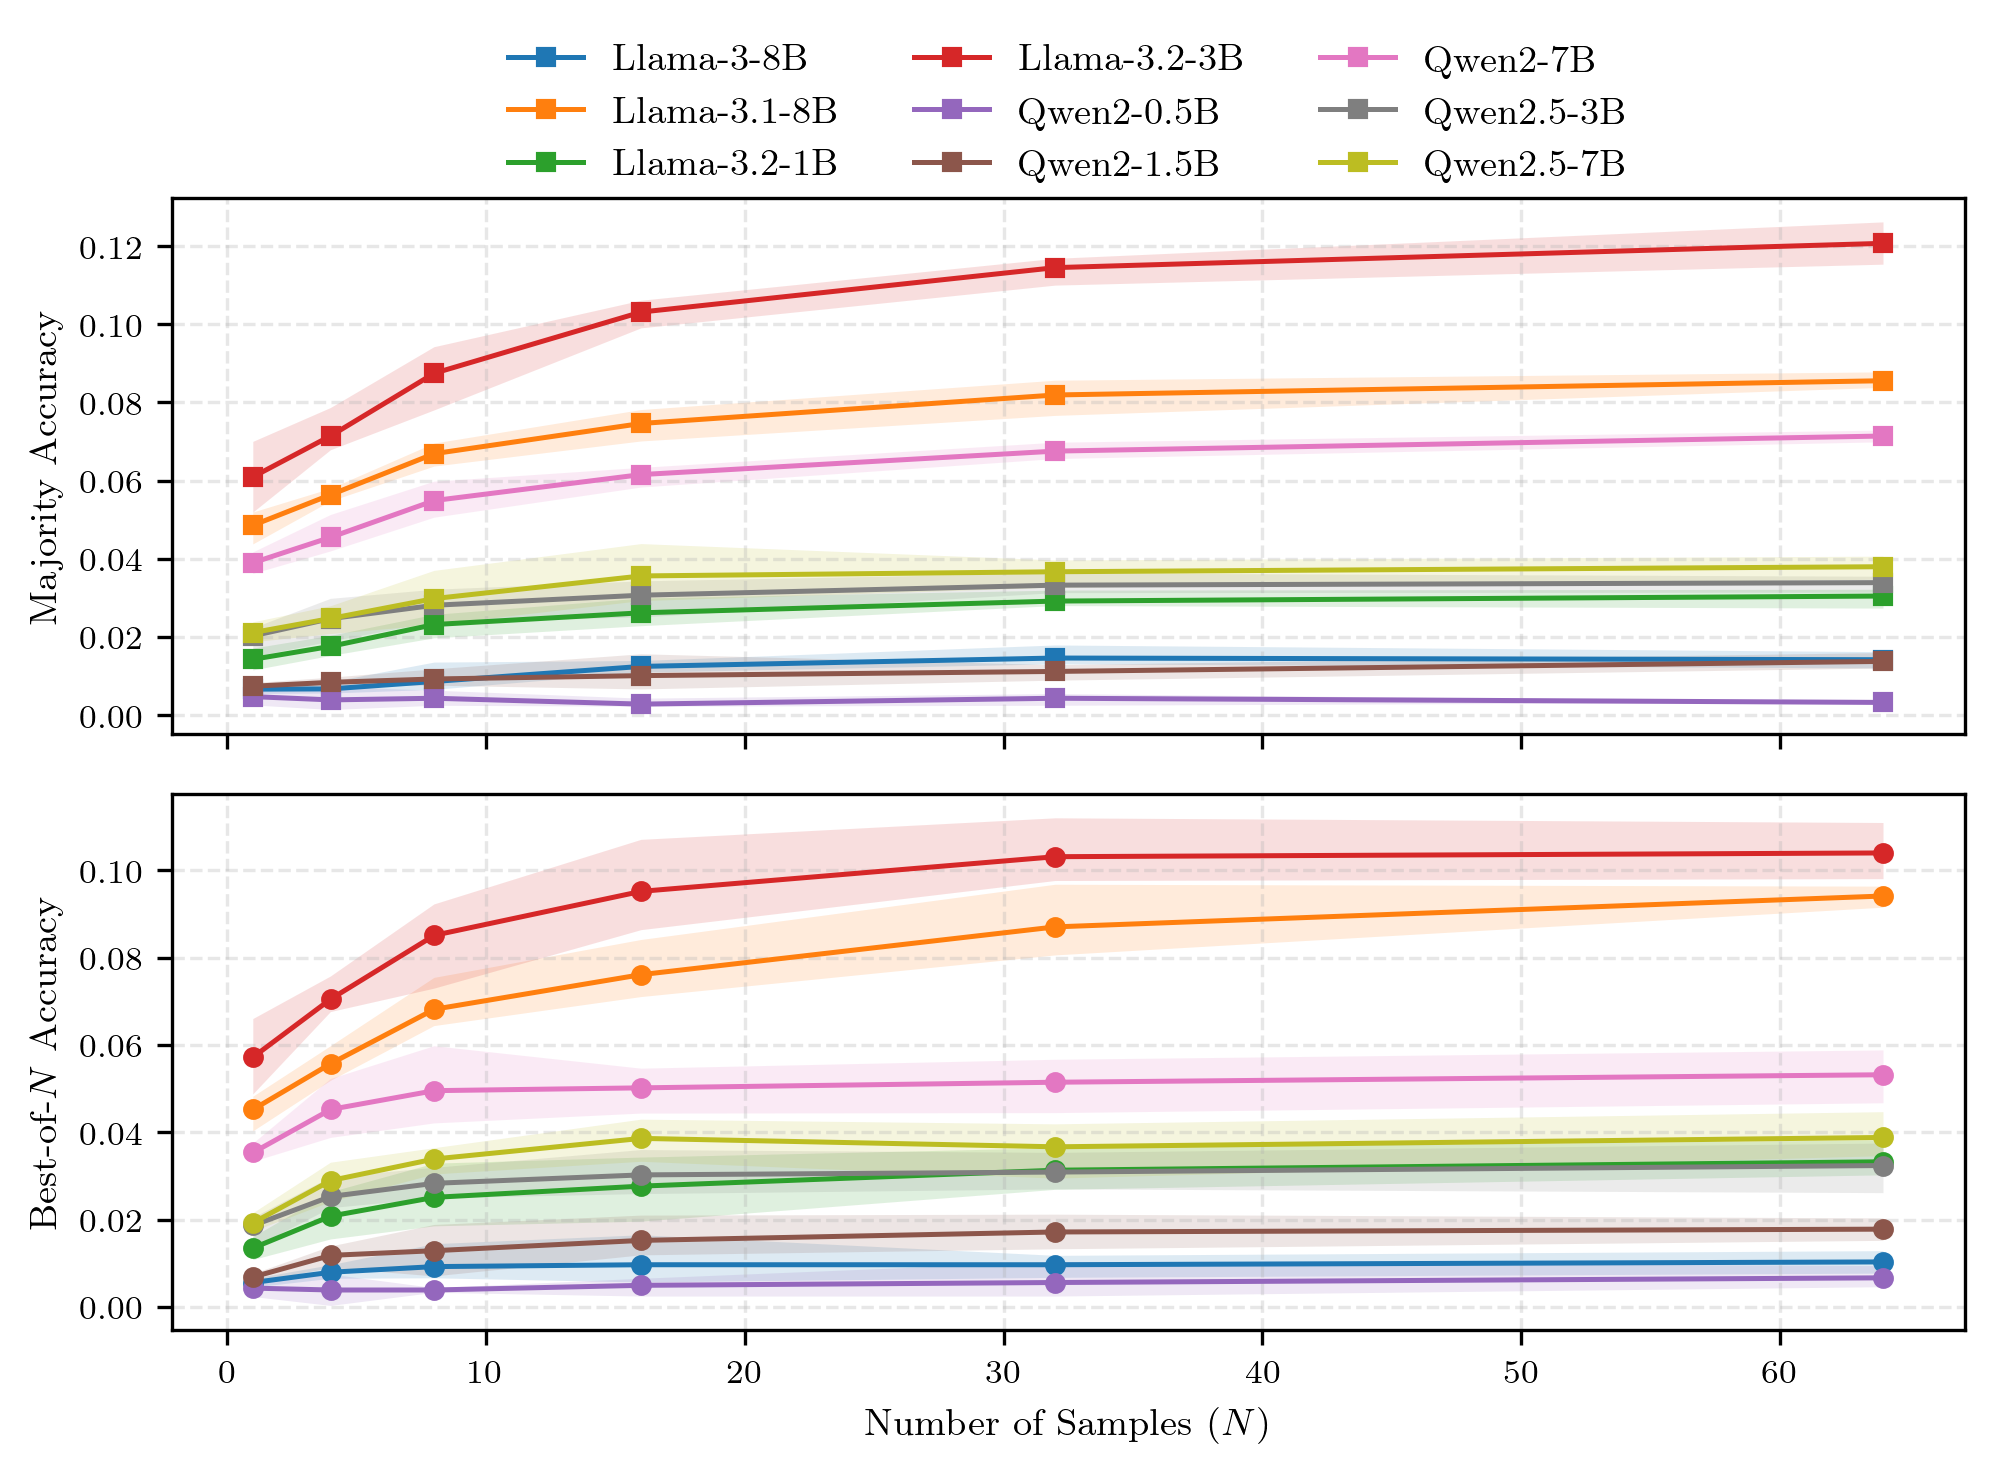

In [7]:
plot_all_curves(
    thetas,
    maj_mean,
    maj_std,
    rew_mean,
    rew_std,
    filename="../figures/GSM8K/curves_absolute.pdf",
)

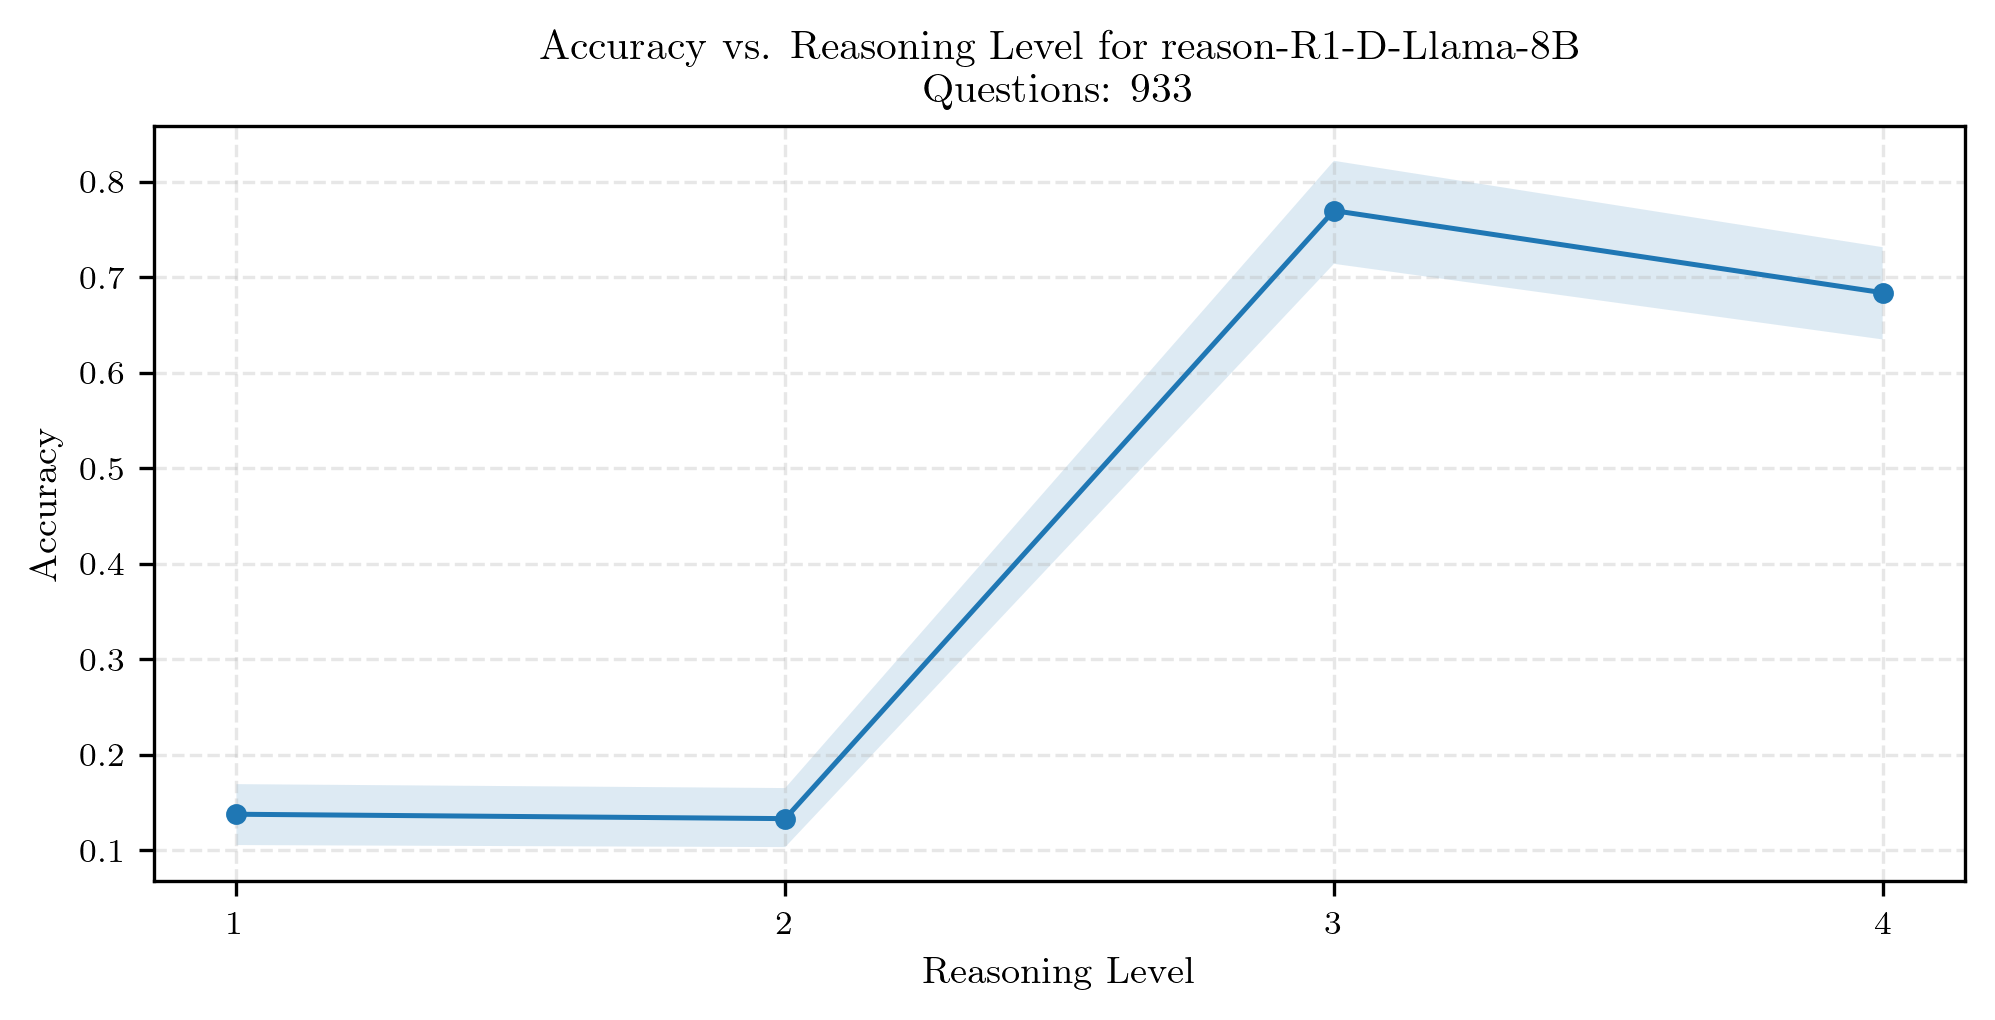

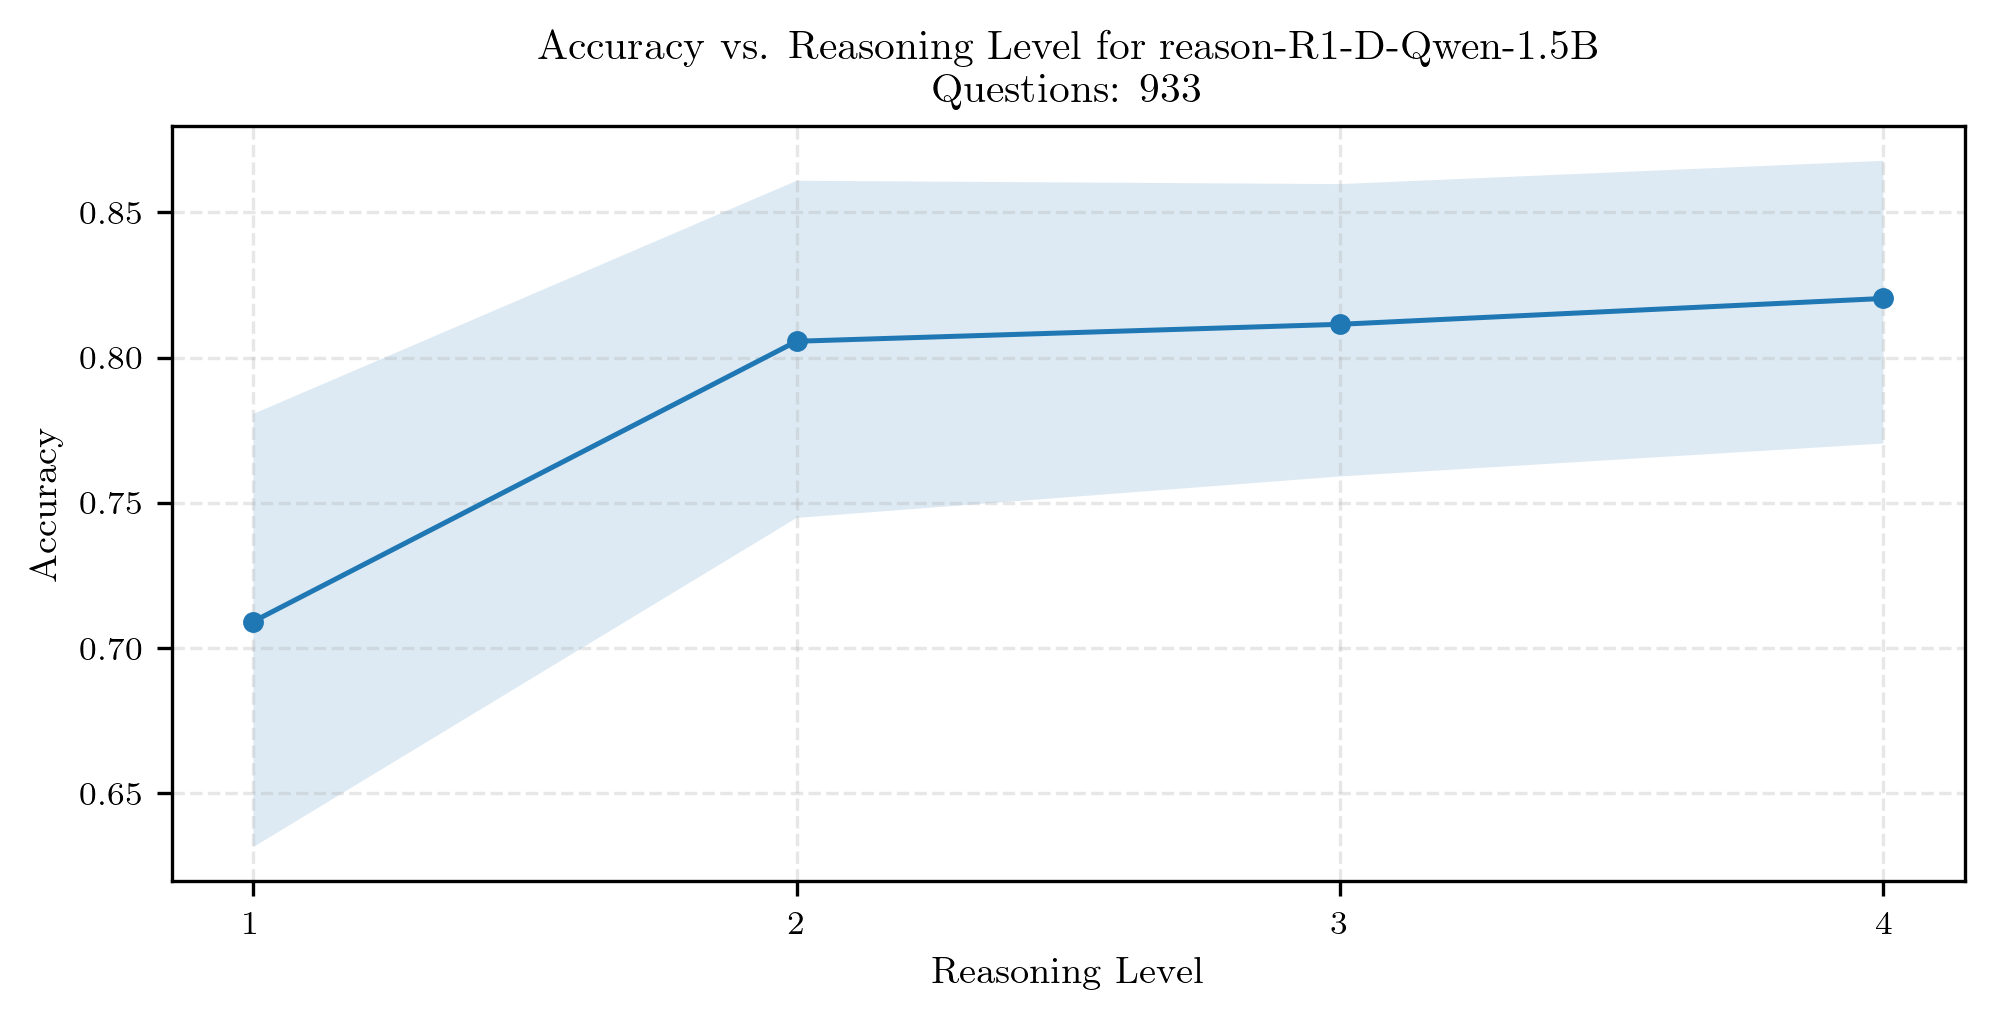

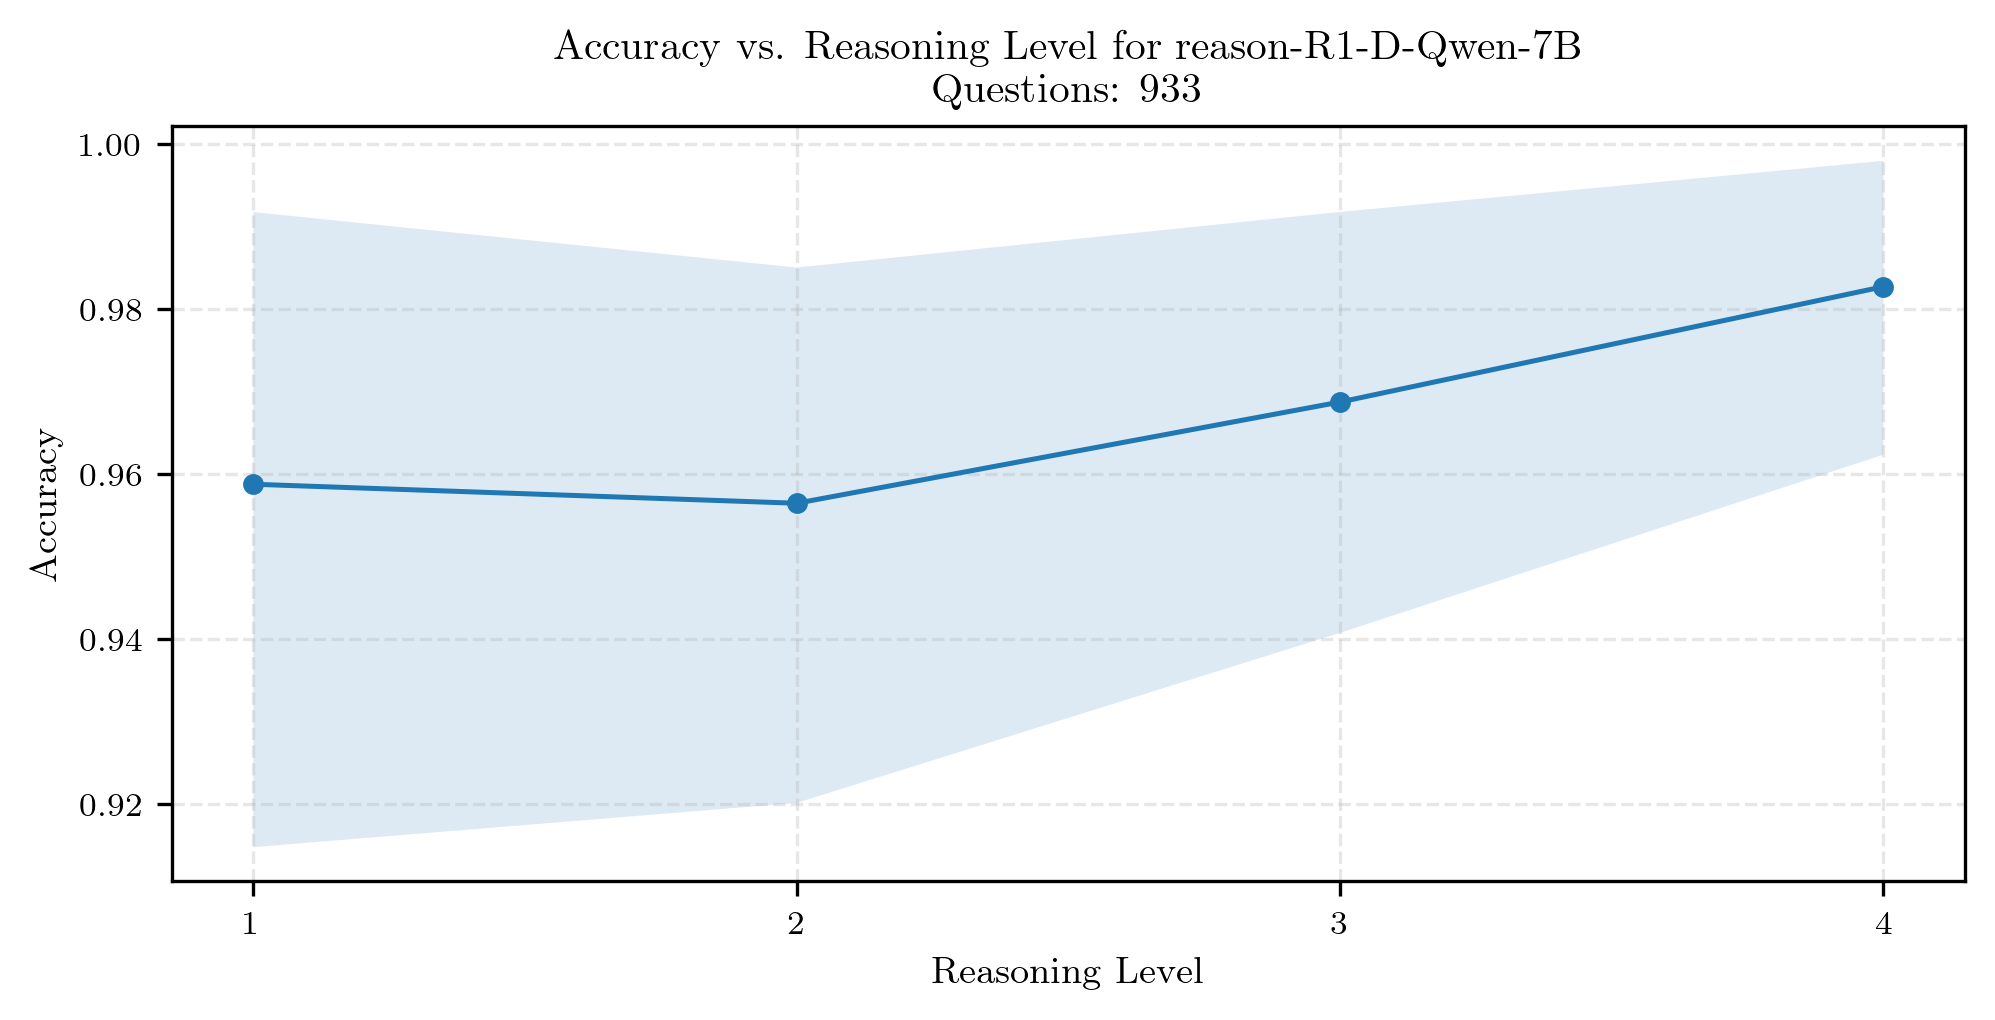

In [10]:
reasoning_accuracy = {}
reasoning_tokens = {}

for model_name in reasoning_models:
    means, stds, tokens, token_stds = reasoning_accuracy_curve_second_custom(
        results[model_name], qs=(0.0, 0.25, 0.50, 0.75, 1.0)
    )

    plot_reasoning_curve_2(
        means,
        stds,
        title="Accuracy vs. Reasoning Level for " + model_name.split("--")[0],
        num_questions=len(results[model_name]["correct"]),
    )

    reasoning_accuracy[model_name] = means
    reasoning_tokens[model_name] = tokens

# Analysis

In [11]:
accuracy = {}
tokens = {}

for model_name in reasoning_models:
    accuracy[model_name] = reasoning_accuracy[model_name]
    tokens[model_name] = reasoning_tokens[model_name]